# ANALISI DATI RACCOLTI CON SCHEDA AUDIO PER CONTATORE GEIGER

## Import dei moduli necessari

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

from scipy.optimize import curve_fit
# from scipy.signal import find_peaks


# Per leggere files audio
import soundfile as sf  

# Per poter andare veloce
from numba import jit


## Carico i dati
- [sr90_20.flac](./sr90_20.flac): ~70mln eventi
- [sr90_25.flac](./sr90_25.flac): ~300mln eventi

In [2]:
%%time

fileToLoad = "sr90_25.flac"
data, samplerate = sf.read(fileToLoad)   
print(data.shape)


# Abbiamo stabilito che si debba usare la seconda colonna
# Credo che siano i due canali audio (?)
data = data[:,1]
print(data.shape)
print(format(data.shape[0], ',').replace(',', ' '))


(287993066, 2)
(287993066,)
287 993 066
CPU times: total: 5.25 s
Wall time: 29.3 s


# Funzione custom findpeaks
Uso il decoratore [`@jit`](https://numba.pydata.org/numba-doc/latest/user/5minguide.html) di numba che mi permette di compilare la funzione, e quindi di eseguirla in modo molto rapido.

In particolare, quando usiamo numba, bisogna abbandonare completamente la *filosofia python* della *vettorizzazione* e fare cicli for espliciti

In [3]:

@jit(nopython=True) # Set "nopython" mode for best performance, equivalent to @njit
def myFindPeaks(vect, threshold = .9): # Function is compiled to machine code when called the first time
        
    currCnt = 0 # <--- Conto quanti punti sono stato su
    currStarting = 0 # <--- Valore temporaneo di un rising edge
    
    isPeak = False # <--- Per sapere se sono oltre soglia 
    lstPeaks = []
    
    for i in range(vect.shape[0]):
        
        # Sono oltre soglia
        if vect[i] > threshold:
        
            # è un rising edge
            if not isPeak:
                isPeak = True
                currCnt = 0
                currStarting = i
                
            if isPeak:
                currCnt +=1 
            
            if currCnt == 10:
                # Lo dichiaro un picco e me lo salvo
                lstPeaks.append(currStarting)
        else:
            isPeak = False
            
    print(f"Ho processato {vect.shape[0]} dati e ho trovato {len(lstPeaks)} picchi")
    return(np.array(lstPeaks))

Chiamo la funzione: la prima volta viene compilata, e la faccio girare su pochi punti, una volta compilata sarà molto più veloce e posso quindi chiamarla sull'intero dataset. Lascio le celle divise così si può avere un'idea dei tempi di esecuzione!

In [4]:
%%time

myThr = .9 # <--- Soglia da oltrepassare

# Chiamo la prima volta, su pochi dati, cosi la funzione si compila
myFindPeaks(data[:10000], myThr)


Ho processato 10000 dati e ho trovato 1 picchi
CPU times: total: 1.73 s
Wall time: 5.9 s


array([4292], dtype=int64)

In [5]:
%%time

# Chiamo ora la funzione compilata sul vero dataset
lstPeaks = myFindPeaks(data, myThr)
len(lstPeaks)

Ho processato 287993066 dati e ho trovato 19188 picchi
CPU times: total: 4.36 s
Wall time: 42.9 s


19188

Il `Wall time` è il tempo che misurerebbe un orologio appeso ad una parete, quanto tempo ci mette in assoluto una cella a girare. Tuttavia il `CPU time` è il tempo effettivo di CPU che è stato usato dal nostro processore per effettuare il lavoro. Notiamo la differenza abissale tra la prima cella (pochi dati, ma con la funzione da compilare) e la seconda (tempo debolmente maggiore a fronte di un incremento ben più significativo dei dati)

# Differenze dei tempi di arrivo e istogramma

Costruisco l'istogramma dei tempi di interarrivo

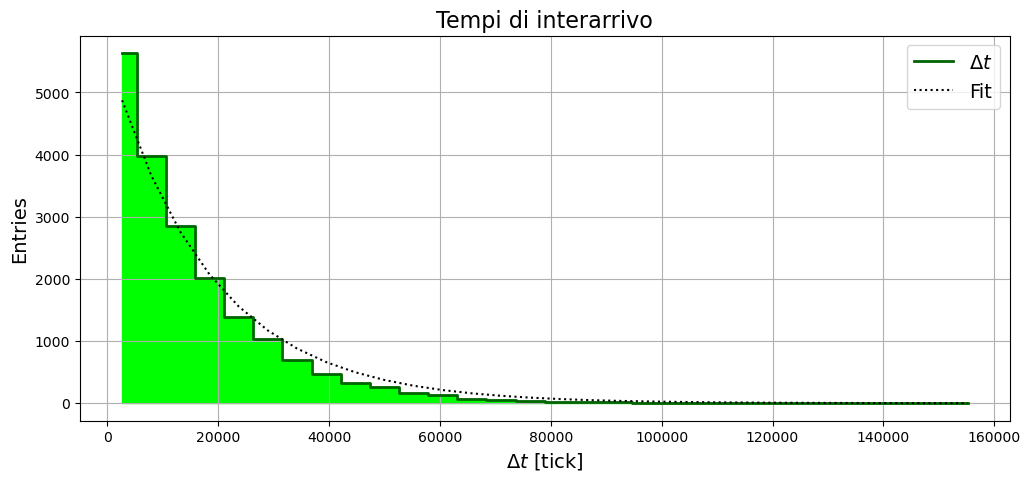

In [6]:
myDiff = np.diff(lstPeaks)



# Istogramma
h, bins = np.histogram(myDiff, bins = 30)
binc = bins[:-1] + (bins[1] - bins[0]) / 2

# Fit
def funToFit(t, a, tau):
    return a * np.exp(-t/tau)

tauGuess = binc[h < (h.max()/np.e)][0]
p0 = (h.max(), tauGuess)

cond = binc < (5*tauGuess)  # <--- Fitto entro 5 tau
xData = binc[cond]
yData = h[cond]
popt, pcov = curve_fit(funToFit, xData, yData, sigma = np.sqrt(yData), absolute_sigma = True, p0 = p0)


fig, ax = plt.subplots()
fig.set_size_inches(12,5)

ax.plot(binc, h, ds = "steps-mid", c = "darkgreen", lw = 2, label = "$\Delta t$")
ax.fill_between(binc, h, step = "mid", color = "lime", alpha = 1)

ax.plot(binc, funToFit(binc, *p0), ls = ":", c = "k", label = "Fit")

ax.set_title("Tempi di interarrivo", fontsize = 16)
ax.set_xlabel("$\Delta t$ [tick]", fontsize = 14)
ax.set_ylabel("Entries", fontsize = 14)
ax.grid()
ax.legend(fontsize = 14)

plt.show()